In [ ]:
!pip install pyspark
!pip install haversine
!pip install seaborn

In [1]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType, StringType

spark=SparkSession.builder.appName('FordGoBike').getOrCreate()
spark

In [2]:
path="G:\My Drive\Develhope\develhope-Data5-Team3\Data\Raw_FordGoBike"
df=spark.read.csv(path,header=True, inferSchema=True)

df.describe().show()

+-------+------------------+-----------------+--------------------+----------------------+-----------------------+-----------------+--------------------+--------------------+---------------------+------------------+----------+------------------+-------------+-----------+
|summary|      duration_sec| start_station_id|  start_station_name|start_station_latitude|start_station_longitude|   end_station_id|    end_station_name|end_station_latitude|end_station_longitude|           bike_id| user_type| member_birth_year|member_gender|     pyment|
+-------+------------------+-----------------+--------------------+----------------------+-----------------------+-----------------+--------------------+--------------------+---------------------+------------------+----------+------------------+-------------+-----------+
|  count|            519700|           519700|              519700|                519700|                 519700|           519700|              519700|              519700|          

In [3]:
df.columns

['duration_sec',
 'start_time',
 'end_time',
 'start_station_id',
 'start_station_name',
 'start_station_latitude',
 'start_station_longitude',
 'end_station_id',
 'end_station_name',
 'end_station_latitude',
 'end_station_longitude',
 'bike_id',
 'user_type',
 'member_birth_year',
 'member_gender',
 'pyment']

In [4]:
df_2=df.withColumn('bigger',F.col('start_time')>F.col('end_time'))



In [5]:
df_2.filter(df_2['bigger']==True).show()

+------------+--------------------+--------------------+----------------+------------------+----------------------+-----------------------+--------------+-----------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+------+
|duration_sec|          start_time|            end_time|start_station_id|start_station_name|start_station_latitude|start_station_longitude|end_station_id| end_station_name|end_station_latitude|end_station_longitude|bike_id| user_type|member_birth_year|member_gender|     pyment|bigger|
+------------+--------------------+--------------------+----------------+------------------+----------------------+-----------------------+--------------+-----------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+------+
|         292|2017-11-05 04:59:...|2017-11-05 04:04:...|             121|Mission Playground|            37.7592103|           -122.4213392|   

##WEEK 1 - Calcualte Haversine Distance

In [6]:
from haversine import haversine

def haversine_f(lat1, lon1, lat2, lon2):
    return haversine( (lat1, lon1), (lat2, lon2),unit='m',normalize=True )

haversine_udf = F.udf(haversine_f)

In [7]:
df=df.withColumn('haversine_distance', 
                    haversine_udf(F.col('start_station_latitude'), F.col('start_station_longitude'), 
                                  F.col('end_station_latitude'), F.col('end_station_longitude'))
                    )

##WEEK 2

##TASK 2 - Calculate the trip cost

In [8]:
df=df.withColumn('Trip_cost',(F.col('duration_sec')/60*0.35))

TASK 3 - Calculate the total distance for each bike and list the top 10

In [9]:
df.groupBy("bike_id").agg(F.sum("haversine_distance").alias("sum_distance")).sort(F.desc("sum_distance")).show(10)

+-------+-----------------+
|bike_id|     sum_distance|
+-------+-----------------+
|     68|743369.4902184182|
|   2178|721182.2309746571|
|    256| 671916.149877458|
|    235|670161.9915671463|
|   2049|656828.0816022325|
|    441|656642.2747553723|
|   2226|647823.2681731757|
|    796|646867.7218100477|
|    190|640294.1746529335|
|   2365|639412.7012101663|
+-------+-----------------+
only showing top 10 rows



##WEEK 3

TASK 1

In [10]:
df.groupby('member_gender').count().show()

+-------------+------+
|member_gender| count|
+-------------+------+
|         null| 66462|
|       Female| 98621|
|        Other|  6299|
|         Male|348318|
+-------------+------+



In [11]:
df11 = df.withColumn('F', F.when(F.col('member_gender') == 'Female', 1).otherwise(0)).withColumn('M', F.when(F.col('member_gender') == 'Male', 1).otherwise(0))

df11.select('F', 'M','member_gender').show(10)

+---+---+-------------+
|  F|  M|member_gender|
+---+---+-------------+
|  0|  1|         Male|
|  0|  1|         Male|
|  0|  1|         Male|
|  0|  1|         Male|
|  0|  1|         Male|
|  0|  1|         Male|
|  0|  1|         Male|
|  0|  1|         Male|
|  0|  1|         Male|
|  0|  1|         Male|
+---+---+-------------+
only showing top 10 rows



In [12]:
from pyspark.sql.functions import desc
df4 = df11.groupBy('start_station_id').agg({'trip(s)':'count', 'F':'sum', 'M': 'sum'}).orderBy(desc('count(trip(s))')).limit(10)

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `trip(s)` cannot be resolved. Did you mean one of the following? [`duration_sec`, `start_time`, `end_time`, `start_station_id`, `start_station_name`, `start_station_latitude`, `start_station_longitude`, `end_station_id`, `end_station_name`, `end_station_latitude`, `end_station_longitude`, `bike_id`, `user_type`, `member_birth_year`, `member_gender`, `pyment`, `haversine_distance`, `Trip_cost`, `F`, `M`].

In [ ]:
df5 = df4.withColumn('F_ratio', df4[1]/df4[3])
#df5.show()
df6 = df5.withColumn('M_ratio', df4[2]/df4[3])
df6.show(10)

TASK 2

In [13]:
df.select('user_type').distinct().show()

+----------+
| user_type|
+----------+
|Subscriber|
|  Customer|
+----------+



In [14]:
df.groupBy('user_type').agg(F.round(F.count('user_type')/df.count()*100, 2).alias('User Percentage')).show()

+----------+---------------+
| user_type|User Percentage|
+----------+---------------+
|Subscriber|          78.74|
|  Customer|          21.26|
+----------+---------------+



TASK 3

In [15]:
df3_3=df.where(F.col('haversine_distance')!=0) #cleaning zero distance entries

In [16]:
df3_3=df3_3.withColumn('age',2017-F.col('member_birth_year')).withColumn('age',F.col('age').cast('int'))

In [17]:
df3_3=df3_3.where((F.col('age')>18) & (F.col('age')<=100)) #cleaning outlier values(age=100+)
df3_3=df3_3.dropna(how='all',subset=['age'])


In [37]:
df=df.withColumn('age',2017-F.col('member_birth_year'))\
    .withColumn('age',F.col('age').cast('int'))\
    .withColumn('age_group', F.when(((F.col('age')>=18) & (F.col('age')<35)),'18 to 35')\
                      .otherwise(F.when((F.col('age')>=35)&(F.col('age')<50),'35 to 50')\
                      .otherwise(F.when((F.col('age')>=50)&(F.col('age')<65),'50 to 65')\
                                 .otherwise(F.when((F.col('age')>=65)&(F.col('age')<=100),'65 to 100').otherwise('non-groupped')))))

In [18]:
df3_3=df3_3.withColumn('age_group', F.when(((F.col('age')>=18) & (F.col('age')<35)),'18 to 35')\
                      .otherwise(F.when((F.col('age')>=35)&(F.col('age')<50),'35 to 50')\
                      .otherwise(F.when((F.col('age')>=50)&(F.col('age')<65),'50 to 65')\
                                 .otherwise(F.when((F.col('age')>=65)&(F.col('age')<=100),'65 to 100').otherwise('non-groupped')))))

df3_3_ag=df3_3.groupby('age_group').agg(F.mean('haversine_distance').alias('Age Group/Distance')).sort(F.col('age_group'))

In [19]:
df3_3_ag=df3_3.groupby('age_group').agg(F.sum('haversine_distance').alias('Age Group/Distance')).sort(F.col('age_group'))

In [39]:
df.where(F.col('age_group')=='non-groupped').count()

66925

In [ ]:
df.write.option("header",True).mode('overwrite').csv('/workspaces/develhope-Data5-Team3/Data/week_3_end_dataset')

In [21]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [22]:
pd=df3_3_ag.toPandas()

pd.head()

,age_group,Age Group/Distance
0,18 to 35,3.752144e+08
1,35 to 50,2.596558e+08
2,50 to 65,8.060019e+07
3,65 to 100,7.605072e+06


Text(-35.30555555555556, 0.5, 'Age Group')

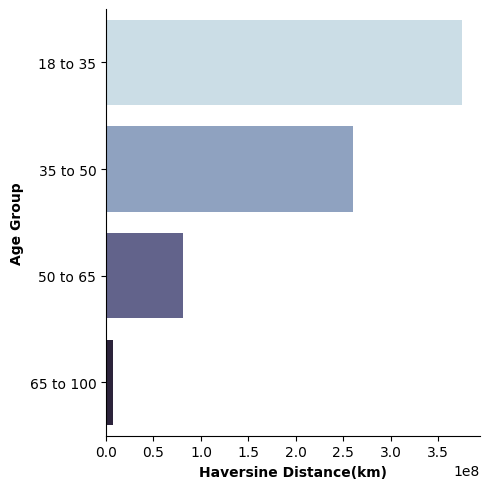

In [23]:
sn.catplot(data=pd, x='Age Group/Distance', y="age_group", errorbar=("pi", 95), kind="bar", palette="ch:s=.25,rot=-.25")
plt.xlabel('Haversine Distance(km)', weight = 'bold')
plt.ylabel('Age Group', weight = 'bold')

In [24]:
df3_3_ng=df3_3.groupBy('age').agg(F.mean('haversine_distance').alias('Avg_Distance')).sort(F.col('Avg_Distance'))

In [25]:
df3_3_ng=df3_3.groupBy('age').agg(F.sum('haversine_distance').alias('Avg_Distance')).sort(F.col('Avg_Distance'))

In [26]:
df3_3_ng.show(100)

+---+--------------------+
|age|        Avg_Distance|
+---+--------------------+
| 89|   36531.58092412224|
| 79|  38671.027405037225|
| 78|   49267.34119869774|
| 83|  58415.822000079184|
| 77|     58667.598173411|
| 84|   73615.35517799917|
| 71|   80300.05416470631|
| 76|   88164.94745103465|
| 82|   89471.33234031532|
| 75|   93201.88222628318|
| 93|  127928.83604280185|
| 74|  188870.11611176943|
| 73|   401854.1935889635|
| 72|  437399.78780941403|
| 69|   627310.4806461799|
| 67|   665882.9726550521|
| 70|   735536.7252390501|
| 68|    756348.347059789|
| 64|   816659.0412061604|
| 66|   1110020.510079633|
| 62|  1498203.8200955822|
| 65|   1887613.118004551|
| 19|   2115202.303170333|
| 60|  2366454.4971427117|
| 20|  2682434.0025500706|
| 63|  2945305.6696901084|
| 21|  3740567.7942226157|
| 58|   3893607.140348861|
| 57|  3911315.8246265347|
| 61|   4342004.007098821|
| 59|   4555075.449304863|
| 56|   5207482.936517287|
| 51|   5657343.884849376|
| 55|   5704852.929169536|
|

Text(0, 0.5, 'Haversine Distance(km)')

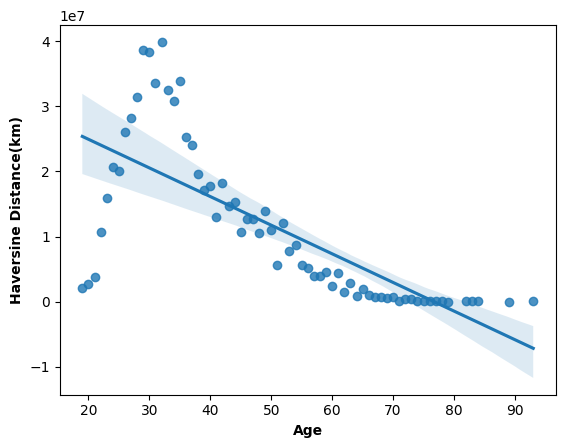

In [27]:
df2=df3_3_ng.toPandas()

sn.regplot(x= "age", y= "Avg_Distance", data=df2)
plt.xlabel('Age', weight = 'bold')
plt.ylabel('Haversine Distance(km)', weight = 'bold')

WEEK 4

#TASK 1

In [28]:
df.groupBy('user_type').agg({'Trip_cost': 'sum'}).show()

+----------+------------------+
| user_type|    sum(Trip_cost)|
+----------+------------------+
|Subscriber|1683699.5700000036|
|  Customer|1648039.3766666679|
+----------+------------------+



#TASK 2

In [29]:
df=df.withColumn('time_of_the_day', F.when(((F.hour('start_time')>=5) & (F.hour('start_time')<12)),'Morning')\
                      .otherwise(F.when((F.hour('start_time')>=12)&(F.hour('start_time')<18),'Afternoon')\
                      .otherwise(F.when((F.hour('start_time')>=18)&(F.hour('start_time')<21),'Evening')\
                                 .otherwise('Night'))))

In [ ]:
df.write.option("header",True).mode('overwrite').csv('/workspaces/develhope-Data5-Team3/Data/week_4_end_dataset')

In [30]:
df_time_of_day=df.groupBy('time_of_the_day').agg(F.count('start_time').alias('total_rents'))

df_time_of_day.show()

+---------------+-----------+
|time_of_the_day|total_rents|
+---------------+-----------+
|        Evening|     129898|
|        Morning|      96965|
|      Afternoon|     174699|
|          Night|     118138|
+---------------+-----------+



In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [32]:
pd=df_time_of_day.toPandas()

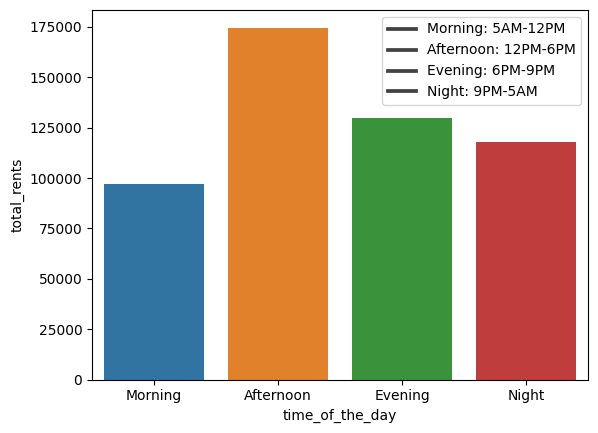

In [33]:
sn.barplot(x= pd["time_of_the_day"], y= pd['total_rents'], data=pd, order=['Morning','Afternoon','Evening','Night'])
plt.legend(['Morning: 5AM-12PM', 'Afternoon: 12PM-6PM','Evening: 6PM-9PM', 'Night: 9PM-5AM'])

In [34]:
df_hour=df.groupBy(F.hour('start_time').alias('hour')).agg(F.count('start_time').alias('total_count')).sort(F.hour('start_time'))
df_hour.show()

+----+-----------+
|hour|total_count|
+----+-----------+
|   0|      11993|
|   1|       7967|
|   2|       4867|
|   3|       2606|
|   4|       1377|
|   5|        860|
|   6|        398|
|   7|        640|
|   8|       2145|
|   9|       8895|
|  10|      26800|
|  11|      57227|
|  12|      45457|
|  13|      25217|
|  14|      24303|
|  15|      27448|
|  16|      27374|
|  17|      24900|
|  18|      28448|
|  19|      41339|
+----+-----------+
only showing top 20 rows



<Axes: xlabel='hour', ylabel='total_count'>

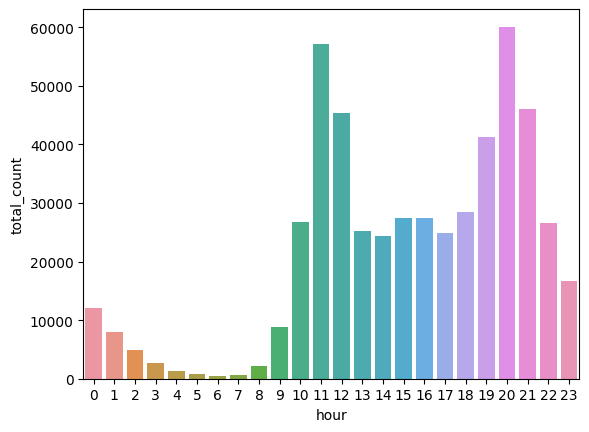

In [35]:
pd_2=df_hour.toPandas()
sn.barplot(x= pd_2["hour"], y= pd_2['total_count'], data=pd_2)

#TASK 3

In [ ]:
df.columns

In [ ]:
df.select(['start_station_name','start_time']).groupBy(['start_station_name', F.hour('start_time').alias('hour')]).agg(F.count('start_time').alias('# of Rents')).sort(['start_station_name','hour']).show(25)


df_station=df.select(['start_station_name','start_time']).groupBy(['start_station_name', F.hour('start_time').alias('hour')]).agg(F.count('start_time').alias('# of Rents')).sort(['start_station_name','hour'])
pd_station=df_station.toPandas()

In [ ]:
plt.figure(figsize=(5,20))
sn.scatterplot(x= pd_station['hour'], y= pd_station['start_station_name'], hue='# of Rents',data=pd_station)
plt.autoscale(enable=True)
plt.xlabel(xlabel='Station Names')
plt.xticks(rotation=90, fontsize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [ ]:
plt.figure(figsize=(35,4))
sn.scatterplot(x= pd_station['start_station_name'], y= pd_station['# of Rents'], hue='hour',data=pd_station)
plt.autoscale(enable=True)
plt.xlabel(xlabel='Station Names')
plt.xticks(rotation=90, fontsize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [ ]:
plt.figure(figsize=(20,10))

sn.histplot(x= pd_station["hour"], y= pd_station['# of Rents'], data=pd_station, kde=True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

WEEK 5
1- what is the ratio of payment using cc or app wallet
2- what is the preferred way to pay for customers and subscriber
3- Analyze the relationship between trip duration and user type (subscriber vs. customer) to understand differences in usage patterns.

#TASK 1

In [40]:
df.groupBy('pyment').agg(F.round(F.count('pyment')/df.count()*100, 2).alias('Payment Percentage')).show()

+-----------+------------------+
|     pyment|Payment Percentage|
+-----------+------------------+
| app wallet|             50.04|
|credit card|             49.96|
+-----------+------------------+



#TASK 2

In [41]:
df.columns

['duration_sec',
 'start_time',
 'end_time',
 'start_station_id',
 'start_station_name',
 'start_station_latitude',
 'start_station_longitude',
 'end_station_id',
 'end_station_name',
 'end_station_latitude',
 'end_station_longitude',
 'bike_id',
 'user_type',
 'member_birth_year',
 'member_gender',
 'pyment',
 'haversine_distance',
 'Trip_cost',
 'time_of_the_day',
 'age',
 'age_group']

In [ ]:
df.groupBy(['user_type','pyment']).agg((F.count('pyment')/F.col(df.select('user_type').count()*100)).alias('Payment Percentage')).sort('user_type').show()

In [ ]:
df.groupBy(['user_type','pyment']).agg({['user_type','pyment'], 'count'}).sort('user_type').show()

In [65]:
df.select('user_type').distinct().show()

+----------+
| user_type|
+----------+
|Subscriber|
|  Customer|
+----------+



In [74]:
df.groupBy('user_type').pivot('pyment').agg(F.count(F.col('pyment'))/F.count(F.col('user_type'))).show()

+----------+----------+-----------+
| user_type|app wallet|credit card|
+----------+----------+-----------+
|Subscriber|       1.0|        1.0|
|  Customer|       1.0|        1.0|
+----------+----------+-----------+



#TASK 3

In [76]:
df.agg(F.count(F.col('pyment'))).show()

+-------------+
|count(pyment)|
+-------------+
|       519700|
+-------------+



In [78]:
from pyspark.sql import Window

In [86]:
user= Window.partitionBy('pyment')
df.withColumn('testtt',F.count('user_type').over(user)).show()

+------------+--------------------+--------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+----------+------------------+------------------+---------------+---+---------+------+
|duration_sec|          start_time|            end_time|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|end_station_id|    end_station_name|end_station_latitude|end_station_longitude|bike_id| user_type|member_birth_year|member_gender|    pyment|haversine_distance|         Trip_cost|time_of_the_day|age|age_group|testtt|
+------------+--------------------+--------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+----------+--

In [72]:
df.groupBy('user_type').agg(F.mean('duration_sec').alias('Mean duration')).show()

+----------+------------------+
| user_type|     Mean duration|
+----------+------------------+
|Subscriber| 705.3104904332527|
|  Customer|2557.4457861862948|
+----------+------------------+

